In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv


In [2]:
# import os
# if os.path.exists('submission.csv'):
#     os.remove('submission.csv')
#     print("Removed existing submission.csv")

In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install catboost --quiet


In [6]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Note: you may need to restart the kernel to use updated packages.


# Importing necessary libraries

In [7]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
train_df = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv")
test_df = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv")
sample_submission_df = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv")
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

In [9]:
train_df.dropna(how='all', inplace=True)
test_df.dropna(how='all', inplace=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Identify data types of different columns

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26500 entries, 0 to 26499
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             26500 non-null  int64  
 1   store_name     26500 non-null  object 
 2   category       26500 non-null  object 
 3   store_address  26500 non-null  object 
 4   latitude       25976 non-null  float64
 5   longitude      25976 non-null  float64
 6   rating_count   26500 non-null  object 
 7   review_time    26500 non-null  object 
 8   review         26500 non-null  object 
 9   rating         26500 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 2.0+ MB


# Descriptive statistics of numerical columns

In [11]:
train_df['rating_count'] = train_df['rating_count'].astype(str).str.replace(',', '').astype(float)
test_df['rating_count'] = test_df['rating_count'].astype(str).str.replace(',', '').astype(float)

numerical_cols = ['latitude', 'longitude', 'rating_count']
stats = train_df[numerical_cols].describe()
stats.describe()

,latitude,longitude,rating_count
count,8.000000,8.000000,8.000000
mean,3273.731123,3181.476241,7196.679737
std,9173.109658,9210.466927,10011.091049
min,5.336112,-121.995421,263.000000
25%,27.939086,-92.442638,1697.750000
50%,34.179207,-78.435666,2558.718948
75%,41.790903,-50.947714,7028.000000
max,25976.000000,25976.000000,26500.000000


# Identifying and handling missing values

In [12]:
print("Missing in train:\n", train_df.isnull().sum()[train_df.isnull().sum() > 0])
print("Missing in test:\n", test_df.isnull().sum()[test_df.isnull().sum() > 0])

for col in ['review', 'store_name', 'category', 'store_address', 'review_time']:
    if col in train_df: train_df[col] = train_df[col].fillna("Unknown")
    if col in test_df: test_df[col] = test_df[col].fillna("Unknown")

median_rc = train_df['rating_count'].median()
train_df['rating_count'].fillna(median_rc, inplace=True)
test_df['rating_count'].fillna(median_rc, inplace=True)


Missing in train:
 latitude     524
longitude    524
dtype: int64
Missing in test:
 latitude     136
longitude    136
dtype: int64


# Duplicates

In [13]:
duplicates = train_df.duplicated().sum()
print(f"Found {duplicates} duplicate rows.")
if duplicates > 0:
    train_df.drop_duplicates(inplace=True)

Found 0 duplicate rows.


# Outlier handling

In [14]:
for col in numerical_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lb, ub = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = train_df[(train_df[col] < lb) | (train_df[col] > ub)]
    print(f"Outliers in {col}: {len(outliers)}")


Outliers in latitude: 0
Outliers in longitude: 0
Outliers in rating_count: 3761


# Visualisations

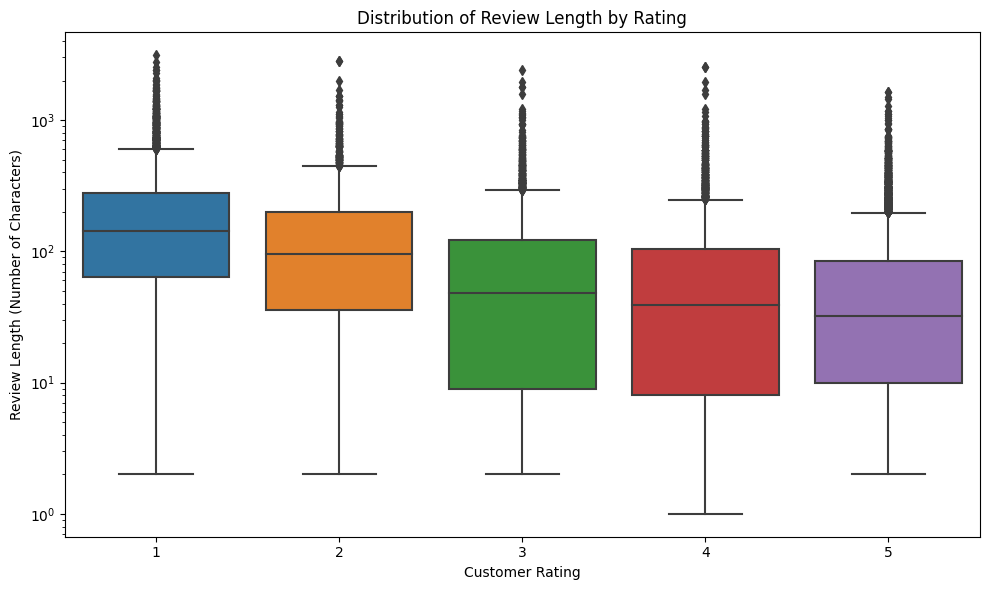

In [15]:
train_df['review_length'] = train_df['review'].astype(str).apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='rating', y='review_length')
plt.title('Distribution of Review Length by Rating')
plt.xlabel('Customer Rating')
plt.ylabel('Review Length (Number of Characters)')
plt.yscale('log') 
plt.tight_layout()

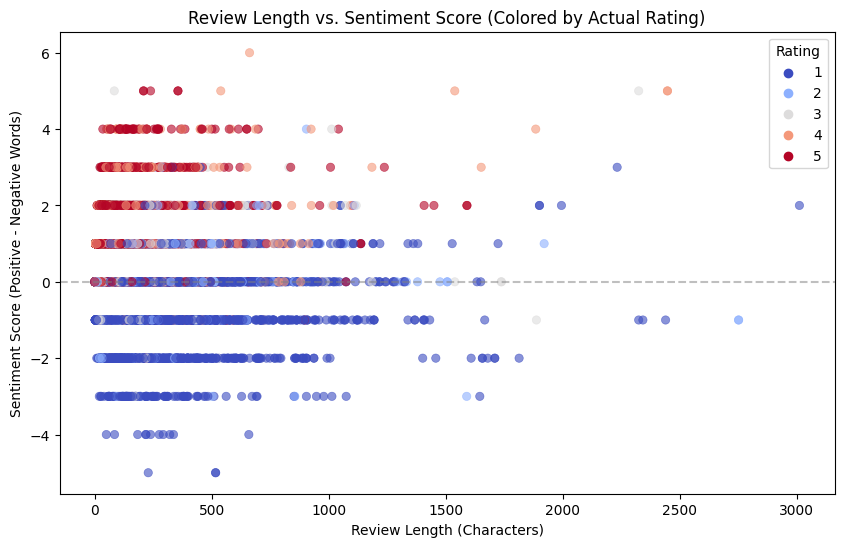

In [16]:
def clean_text(text):
    return re.sub(r'[^a-zA-Z\s]', '', str(text).lower())

def get_sentiment_score(text):
    positive_words = {'good', 'great', 'excellent', 'amazing', 'love', 'best', 'nice', 'friendly', 'fast', 'clean'}
    negative_words = {'bad', 'terrible', 'awful', 'worst', 'hate', 'rude', 'dirty', 'slow', 'broken', 'horrible', 'avoid'}

    words = set(text.split())
    pos_count = len(words & positive_words)
    neg_count = len(words & negative_words)
    
    return pos_count - neg_count

train_df['cleaned_review'] = train_df['review'].apply(clean_text)
train_df['review_length'] = train_df['cleaned_review'].apply(len)
train_df['sentiment_score'] = train_df['cleaned_review'].apply(get_sentiment_score)

valid_reviews = train_df[train_df['review_length'] > 0]

corr = valid_reviews['review_length'].corr(valid_reviews['sentiment_score'])
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=valid_reviews,
    x='review_length',
    y='sentiment_score',
    hue='rating',
    palette='coolwarm',
    alpha=0.6,
    edgecolor=None
)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.title('Review Length vs. Sentiment Score (Colored by Actual Rating)')
plt.xlabel('Review Length (Characters)')
plt.ylabel('Sentiment Score (Positive - Negative Words)')
plt.legend(title='Rating', loc='upper right')


Text(0.5, 1.02, 'Pairwise Relationships Between Numerical Features by Rating')

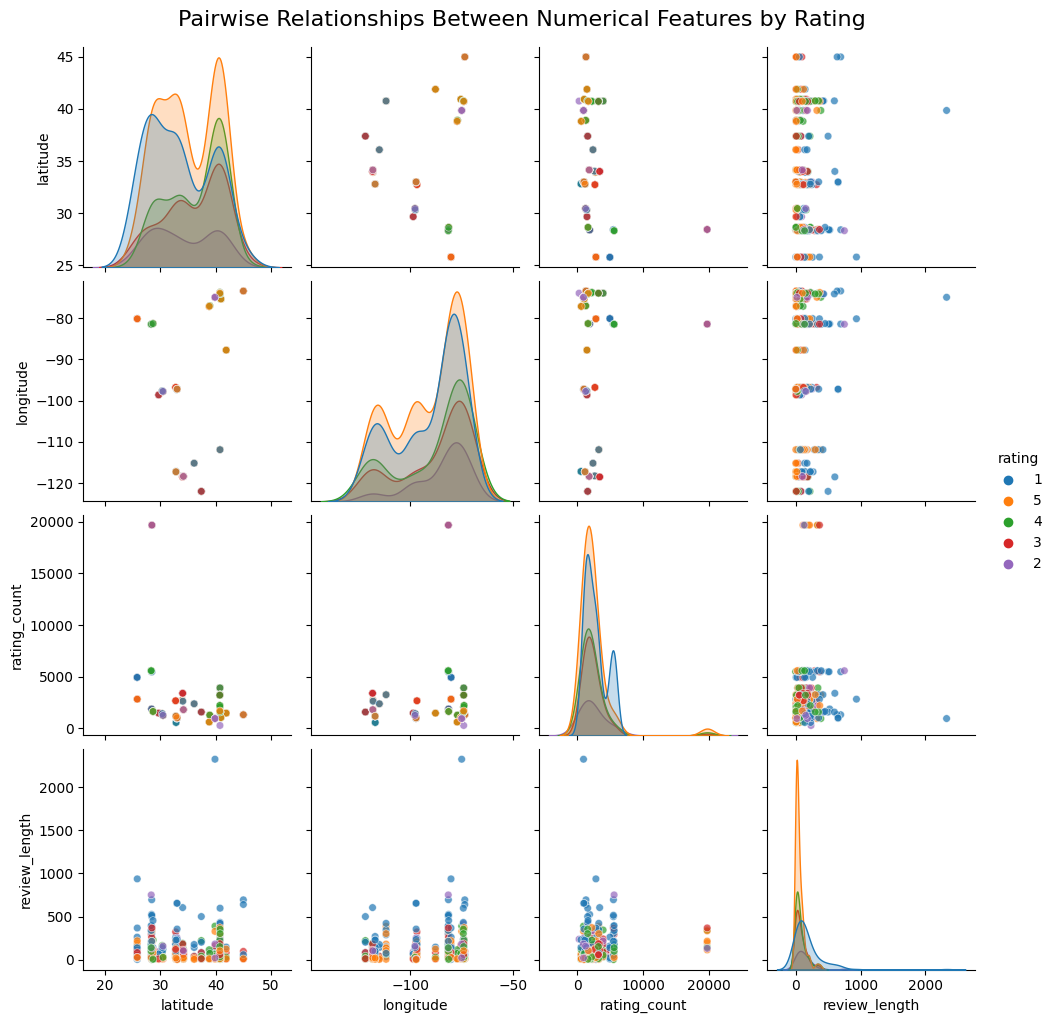

In [17]:
pair_data = train_df[['latitude', 'longitude', 'rating_count', 'review_length', 'rating']].copy()
pair_data['rating'] = pair_data['rating'].astype(str)


pair_sample = pair_data.sample(n=min(500, len(pair_data)), random_state=42)

sns.pairplot(pair_sample, hue='rating', palette='tab10', plot_kws={'alpha': 0.7, 's': 30})
plt.suptitle('Pairwise Relationships Between Numerical Features by Rating', y=1.02, fontsize=16)


In [18]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower().strip()

train_df['cleaned_review'] = train_df['review'].apply(clean_text)
test_df['cleaned_review'] = test_df['review'].apply(clean_text)


# Scaling and Encoding

In [19]:
le_cat = LabelEncoder()
combined_cat = pd.concat([train_df['category'], test_df['category']], ignore_index=True)
le_cat.fit(combined_cat)
train_df['category_encoded'] = le_cat.transform(train_df['category'])
test_df['category_encoded'] = le_cat.transform(test_df['category'])

scaler = StandardScaler()
num_cols = ['latitude', 'longitude', 'rating_count']
X_train_scaled = scaler.fit_transform(train_df[num_cols])
X_test_scaled = scaler.transform(test_df[num_cols])

train_num_df = pd.DataFrame(X_train_scaled, columns=[f"{c}_scaled" for c in num_cols])
test_num_df = pd.DataFrame(X_test_scaled, columns=[f"{c}_scaled" for c in num_cols])


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Convert reviews to list
train_reviews = train_df['cleaned_review'].tolist()
test_reviews = test_df['cleaned_review'].tolist()

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000,  # adjust size as needed
                        ngram_range=(1,2),  # unigrams + bigrams
                        stop_words='english')

# Fit on train reviews and transform both train & test
print("Transforming training reviews...")
train_embeddings = tfidf.fit_transform(train_reviews)

print("Transforming test reviews...")
test_embeddings = tfidf.transform(test_reviews)

# Convert to DataFrame
train_emb_df = pd.DataFrame(train_embeddings.toarray(), columns=tfidf.get_feature_names_out())
test_emb_df = pd.DataFrame(test_embeddings.toarray(), columns=tfidf.get_feature_names_out())

print("TF-IDF embedding shape:")
print("Train:", train_emb_df.shape)
print("Test:", test_emb_df.shape)


Transforming training reviews...
Transforming test reviews...
TF-IDF embedding shape:
Train: (26500, 5000)
Test: (7000, 5000)


In [21]:
X = pd.concat([
    train_num_df.reset_index(drop=True),
    train_df[['category_encoded']].reset_index(drop=True),
    train_emb_df.reset_index(drop=True)
], axis=1)

y = train_df['rating'].astype(int)

X_test_final = pd.concat([
    test_num_df.reset_index(drop=True),
    test_df[['category_encoded']].reset_index(drop=True),
    test_emb_df.reset_index(drop=True)
], axis=1)

print("Final train shape:", X.shape)
print("Final test shape:", X_test_final.shape)

# Ensure no NaN
print("NaN in X:", X.isnull().sum().sum())
print("NaN in X_test:", X_test_final.isnull().sum().sum())


Final train shape: (26500, 5004)
Final test shape: (7000, 5004)
NaN in X: 1048
NaN in X_test: 272


# Models

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def make_pipeline(model):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

models = {
    'LogisticRegression': make_pipeline(LogisticRegression()),
    'RandomForest': make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42)),
    'GradientBoosting': make_pipeline(GradientBoostingClassifier(random_state=42)),
    'AdaBoost': make_pipeline(AdaBoostClassifier(random_state=42)),
    'ExtraTrees': make_pipeline(ExtraTreesClassifier(n_estimators=100, random_state=42)),
    'KNN': make_pipeline(KNeighborsClassifier()),
    'GaussianNB': make_pipeline(GaussianNB()),
    'LGBM': make_pipeline(lgb.LGBMClassifier(random_state=42, verbose=-1)),
}

In [23]:
model_performance = {}
for name, model in models.items():
    print(f"Training {name}...")
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        model_performance[name] = acc
        print(f"{name} Accuracy: {acc:.4f}")
    except Exception as e:
        print(f"Failed to train {name}: {e}")

Training LogisticRegression...
LogisticRegression Accuracy: 0.6143
Training RandomForest...
RandomForest Accuracy: 0.6843
Training GradientBoosting...
GradientBoosting Accuracy: 0.6175
Training AdaBoost...
AdaBoost Accuracy: 0.6004
Training ExtraTrees...
ExtraTrees Accuracy: 0.6900
Training KNN...
KNN Accuracy: 0.5168
Training GaussianNB...
GaussianNB Accuracy: 0.3902
Training LGBM...
LGBM Accuracy: 0.6615


# Hyperparameter tuning

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
def make_pipeline(model):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

In [25]:
print("Tuning LightGBM...")
lgbm_params = {
    'estimator__n_estimators': [150, 200],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__num_leaves': [31, 63],
    'estimator__max_depth': [8, 12]
}
lgbm_grid = GridSearchCV(
    make_pipeline(lgb.LGBMClassifier(random_state=42, verbose=-1)),
    lgbm_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
lgbm_grid.fit(X_train, y_train)
lgbm_best = lgbm_grid.best_estimator_
print("Best LGBM Params:", lgbm_grid.best_params_)

print("Tuning ExtraTrees...")
et_params = {
    'estimator__n_estimators': [100, 150],
    'estimator__max_depth': [None, 15],
    'estimator__min_samples_split': [2, 5]
}
et_grid = GridSearchCV(
    make_pipeline(ExtraTreesClassifier(random_state=42)),
    et_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
et_grid.fit(X_train, y_train)
et_best = et_grid.best_estimator_
print("Best ExtraTrees Params:", et_grid.best_params_)

print("Tuning RandomForest...")
rf_params = {
    'estimator__n_estimators': [100, 150],
    'estimator__max_depth': [None, 12],
    'estimator__min_samples_split': [2, 4]
}
rf_grid = GridSearchCV(
    make_pipeline(RandomForestClassifier(random_state=42)),
    rf_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print("Best RandomForest Params:", rf_grid.best_params_)

models_tuned = {
    'LGBM_Tuned': lgbm_best,
    'ExtraTrees_Tuned': et_best,
    'RandomForest_Tuned': rf_best
}

val_accuracies = {}
for name, model in models_tuned.items():
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    val_accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Tuning LightGBM...
Best LGBM Params: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 12, 'estimator__n_estimators': 200, 'estimator__num_leaves': 63}
Tuning ExtraTrees...
Best ExtraTrees Params: {'estimator__max_depth': None, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 150}
Tuning RandomForest...
Best RandomForest Params: {'estimator__max_depth': None, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 150}
LGBM_Tuned Accuracy: 0.6640
ExtraTrees_Tuned Accuracy: 0.6958
RandomForest_Tuned Accuracy: 0.6874


In [26]:
weights = [
    val_accuracies['LGBM_Tuned'],
    val_accuracies['ExtraTrees_Tuned'],
    val_accuracies['RandomForest_Tuned']
]
print(f"Ensemble Weights (based on val accuracy): {weights}")

voting_clf = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_best),
        ('et', et_best),
        ('rf', rf_best)
    ],
    voting='hard',
    weights=weights
)

voting_clf.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

final_predictions = voting_clf.predict(X_test_final)

submission = pd.DataFrame({
    'id': test_df['id'],
    'rating': final_predictions.astype(int)
})
submission.to_csv('submission.csv', index=False)

Ensemble Weights (based on val accuracy): [0.6639622641509434, 0.6958490566037736, 0.6873584905660377]


# Comparison of model performance

In [27]:
for name, acc in val_accuracies.items():
    print(f"{name}: {acc:.4f}")

LGBM_Tuned: 0.6640
ExtraTrees_Tuned: 0.6958
RandomForest_Tuned: 0.6874


Detailed Performance Table:
                Model  Accuracy  Type
0          ExtraTrees  0.690000  Base
1        RandomForest  0.684340  Base
2                LGBM  0.661509  Base
3    GradientBoosting  0.617547  Base
4  LogisticRegression  0.614340  Base
5            AdaBoost  0.600377  Base
6                 KNN  0.516792  Base
7          GaussianNB  0.390189  Base


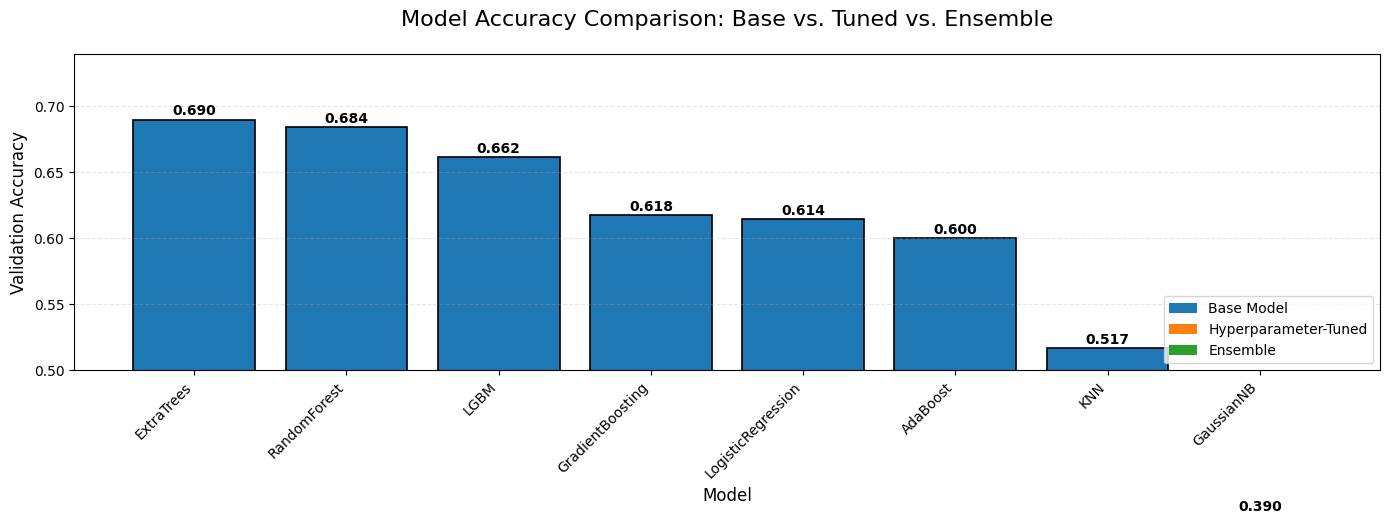

In [28]:
results_df = pd.DataFrame(list(model_performance.items()), columns=['Model', 'Accuracy'])
results_df['Type'] = results_df['Model'].apply(
    lambda x: 'Tuned' if 'Tuned' in x 
    else 'Ensemble' if 'Ensemble' in x or x in ['Voting', 'Stacking'] 
    else 'Base'
)

results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

best_model = results_df.loc[results_df['Accuracy'].idxmax()]

print("Detailed Performance Table:")
print(results_df.to_string(index=True))


plt.figure(figsize=(14, 6))
colors = results_df['Type'].map({
    'Base': '#1f77b4',      
    'Tuned': '#ff7f0e',     
    'Ensemble': '#2ca02c'   
})

bars = plt.bar(results_df['Model'], results_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.2)

for bar, acc in zip(bars, results_df['Accuracy']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Model Accuracy Comparison: Base vs. Tuned vs. Ensemble', fontsize=16, pad=20)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.ylim(0.5, max(results_df['Accuracy']) + 0.05)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', label='Base Model'),
    Patch(facecolor='#ff7f0e', label='Hyperparameter-Tuned'),
    Patch(facecolor='#2ca02c', label='Ensemble')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('model_comparison_detailed.png', dpi=150)
plt.show()